In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from matplotlib import style
style.use("ggplot")

In [2]:
nursing_df = pd.read_csv('../output_data/model_data.csv')

In [3]:
nursing_df.head().T

,0,1,2,3,4
Cum GPA,2.84,3.14,3.22,3.29,3.38
TEAS Count,1,1,1,2,2
MaxOfTestScore,76,74.7,75.3,77.3,72.7
failing grade count,0,0,0,0,0
Time to Test (days),209,73,84.51,60,80.33
Completion Time (days),591,467,578,591,600
PrecEducDesc,High School/GED/Some College,High School/GED/Some College,High School/GED/Some College,High School/GED/Some College,Associates
Grade,Pass,Pass,Pass,Fail,Pass
GradePass,1,1,1,0,1
HighSchool,1,1,1,1,0


In [4]:
params = {'n_estimators': 50000,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.001}
reg = ensemble.GradientBoostingClassifier(**params)

In [5]:
nursing_df_pass = nursing_df[nursing_df["GradePass"]== 1]
len(nursing_df_pass)

898

In [6]:
nursing_df_fail = nursing_df[nursing_df["GradePass"] != 1]
len(nursing_df_fail)

327

In [7]:
new_data = pd.concat([nursing_df_fail ,nursing_df_pass.sample(n=len(nursing_df_fail)) ],copy=True,ignore_index=True)
len(new_data)

654

In [8]:
data = new_data.values
X = data[:, 0:6]
y = data[:, 6]

In [9]:
pd.value_counts(y)

High School/GED/Some College    563
Bachelors                        49
Associates                       37
Masters                           5
dtype: int64

In [10]:
#load in the data
# Assign the data to X and y

X = new_data[["Cum GPA", "TEAS Count","MaxOfTestScore","failing grade count","Time to Test (days)","Completion Time (days)",
        "HighSchool", "Assoc","Bach","Masters"]]

y = new_data["GradePass"].values#.reshape(-1, 1)
print(X.shape, y.shape)

(654, 10) (654,)


In [11]:
#split the data into training bit

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=13)


In [12]:
#fit the regression model

reg = ensemble.GradientBoostingClassifier(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.3636


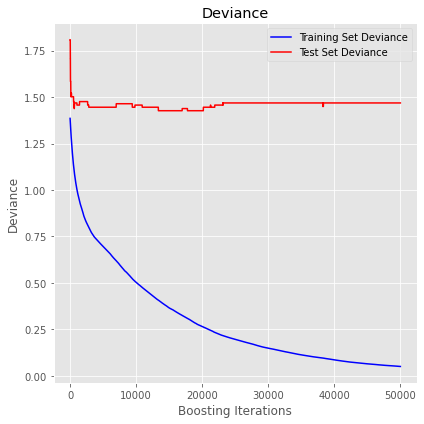

In [13]:
#plot training deviance and plot results

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

In [14]:
data_df = X
data_df.head()

,Cum GPA,TEAS Count,MaxOfTestScore,failing grade count,Time to Test (days),Completion Time (days),HighSchool,Assoc,Bach,Masters
0,3.29,2.0,77.3,0,60.00,591.0,1.0,0.0,0.0,0.0
1,2.78,2.0,74.0,0,369.00,465.0,1.0,0.0,0.0,0.0
2,2.79,3.0,74.0,0,116.00,591.0,1.0,0.0,0.0,0.0
3,3.27,2.0,68.7,1,124.58,578.0,0.0,1.0,0.0,0.0
4,2.76,2.0,73.3,0,158.00,460.0,1.0,0.0,0.0,0.0


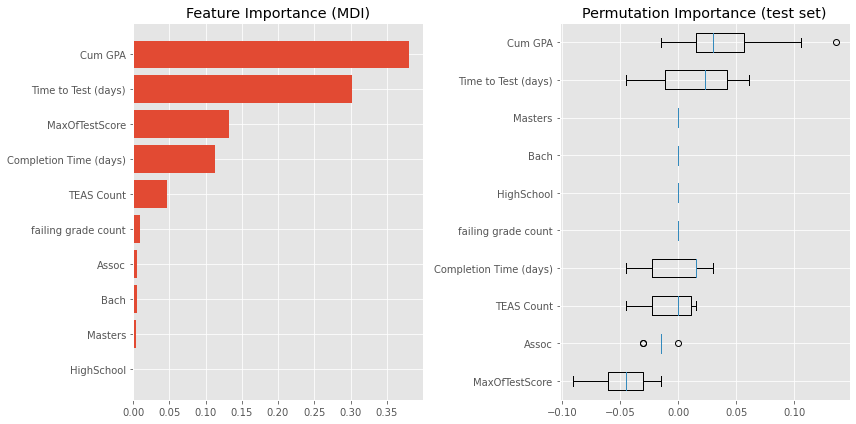

In [15]:
#plot feature importance

feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, data_df.columns[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels= data_df.columns[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [16]:
y_predict = reg.predict(X_test)
y_predict

array([0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
       0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.])

In [17]:
y_test

array([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1.])

In [19]:
 # Calculate classification report
from sklearn.metrics import classification_report
class_report = classification_report(y_test, y_predict, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
class_report_df.to_csv('Outputs/gboost_report.csv')
print(classification_report(y_test, reg.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.74      0.59      0.66        39
         1.0       0.54      0.70      0.61        27

    accuracy                           0.64        66
   macro avg       0.64      0.65      0.64        66
weighted avg       0.66      0.64      0.64        66

